# Day 09: Monochrome

Today, I want to learn how to create hillshade from elevation/terrain raster data.

There are a variety of data sources I will use throughout these exercises, including:
* [Explorer Basemap](https://visibleearth.nasa.gov/images/147190/explorer-base-map): Joshua Stevens, NASA Earth Observatory
* [Comprehensive Global Administrative Zones (CGAZ)](https://www.geoboundaries.org/): geoBoundaries 4.0, William & Mary geoLab
* [Marine polys and lakes](https://www.naturalearthdata.com/): Natural Earth
* [World Cities](https://simplemaps.com/data/world-cities): Simple Maps

Data sources specific to a single day will be linked in the notebook where they appear.

## Configuration

In [1]:
import os
import requests
import matplotlib.pyplot as plt 
import matplotlib.patheffects as PathEffects
import geopandas as gpd
import pandas as pd
import numpy as np
from osgeo import gdal
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Digital elevation model
Use the `elevation` package to read in [NASA SRTM 90m DEM data](https://lpdaac.usgs.gov/products/srtmgl1nv003/) within a certain bounding box. Simple instructions to visualize elevation contours from raster DEM models can be found [here](https://www.earthdatascience.org/tutorials/visualize-digital-elevation-model-contours-matplotlib/).

In [2]:
# Choose bounding box
llcrnrlon=-81
llcrnrlat=-5
urcrnrlon=-75
urcrnrlat=2
bbox = [llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat]

# Choose location name
location = "Ecuador"

In [3]:
# # Choose bounding box
# llcrnrlon=20
# llcrnrlat=35
# urcrnrlon=27
# urcrnrlat=41
# bbox = [llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat]

# # Choose location name
# location = "Greece"

In [4]:
# Choose desired file name
filename = f"{location}-90m-DEM.tif"

# Download DEM file for that bounding box
!eio --product SRTM3 clip -o $filename --bounds $llcrnrlon $llcrnrlat $urcrnrlon $urcrnrlat

make: Nothing to be done for `download'.
make: Nothing to be done for `all'.
cp SRTM3.vrt SRTM3.00a3bb4b11ef447489b72c0e6b706f7c.vrt
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin -81.0 2.0 -75.0 -5.0 SRTM3.00a3bb4b11ef447489b72c0e6b706f7c.vrt /Users/npaul/GEM/30-day-map-challenge/notebooks/Ecuador-90m-DEM.tif
rm -f SRTM3.00a3bb4b11ef447489b72c0e6b706f7c.vrt


In [5]:
# Read the data and metadata
gdal_data = gdal.Open(filename)
gdal_band = gdal_data.GetRasterBand(1)
nodataval = gdal_band.GetNoDataValue()

# Convert to a numpy array
data_array = gdal_data.ReadAsArray().astype(np.float)

# Replace no data values
if np.any(data_array == nodataval):
    data_array[data_array == nodataval] = np.nan

# Calculate hillshade
The function to calculate the hillshade was found in the [GeoExamples blog](https://geoexamples.blogspot.com/2014/03/shaded-relief-images-using-gdal-python.html).

In [6]:
# Utility function
def hillshade(array, azimuth, angle_altitude):
    ''' This function is taken from the GeoExamples blog: 
    https://geoexamples.blogspot.com/2014/03/shaded-relief-images-using-gdal-python.html'''

    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi / 180.
    altituderad = angle_altitude*np.pi / 180.
     
 
    shaded = np.sin(altituderad) * np.sin(slope)\
     + np.cos(altituderad) * np.cos(slope)\
     * np.cos(azimuthrad - aspect)
    return 255*(shaded + 1)/2

# Calculate hillshade
hs_array = hillshade(data_array, 315, 45)

# Construct map

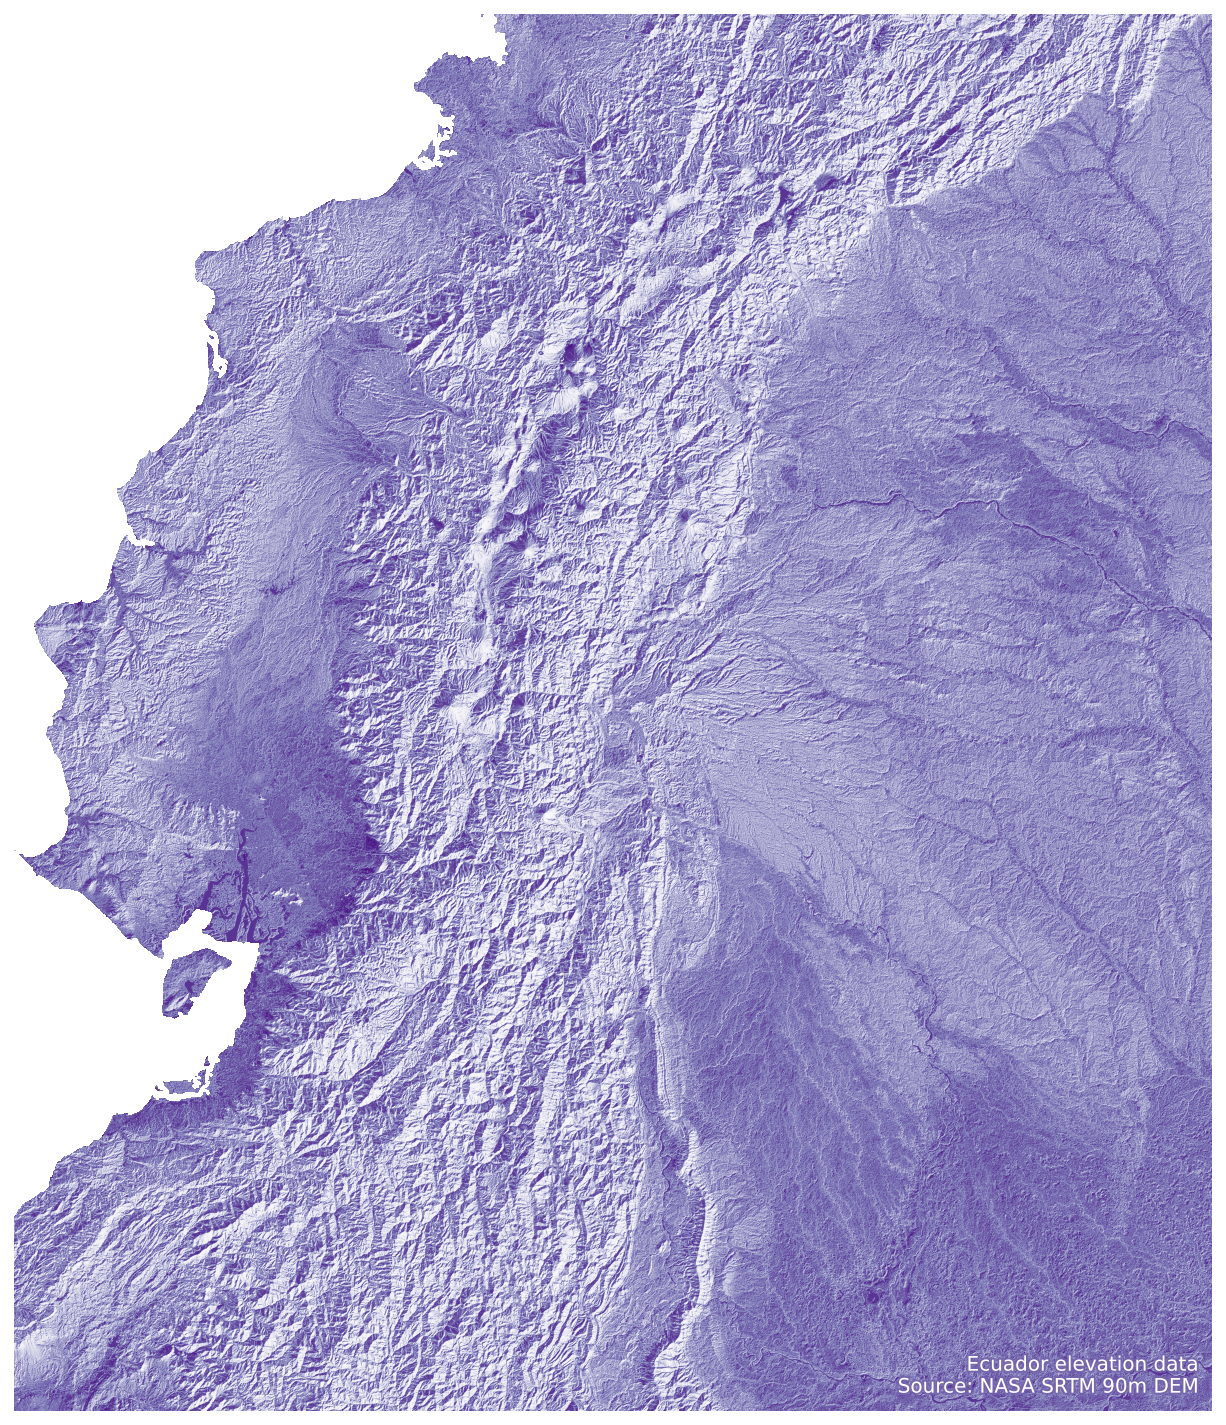

In [7]:
# Arrange annotation
anno_frac, ha = (0.99,0.01), 'right'
# anno_frac, ha = (0.01,0.01), 'left'
anno = f"{location.replace('_','').title()} elevation data\nSource: NASA SRTM 90m DEM"

# Plot hillshade
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(hs_array, cmap='Purples')
ax.axis('off')
ax.annotate(anno,
            xy=anno_frac,
            color="w",
            xycoords='axes fraction',
            ha=ha,
            va='bottom',
            path_effects=[
                            PathEffects.withStroke(
                                linewidth=2,
                                foreground="#7465ac",
                                alpha=0.8)
                            ]
           )

# Save map
out_folder = os.path.join("..", "contributions")
out_path = os.path.join(out_folder, f"09_{location.title()}.png")
plt.tight_layout()
fig.savefig(out_path, dpi=300, facecolor="w", bbox_inches='tight')

# Preview
plt.show()